# Julia is fast

Very often, benchmarks are used to compare languages.  These benchmarks can lead to long discussions, first as to exactly what is being benchmarked and secondly what explains the differences.  These simple questions can sometimes get more complicated than you at first might imagine.

The purpose of this notebook is for you to see a simple benchmark for yourself.  One can read the notebook and see what happened on the author's Macbook Pro with a 4-core Intel Core I7, or run the notebook yourself.

(This material began life as a wonderful lecture by Steven Johnson at MIT: https://github.com/stevengj/18S096/blob/master/lectures/lecture1/Boxes-and-registers.ipynb.)

# Outline of this notebook

- Define the sum function
- Implementations & benchmarking of sum in...
    - C (hand-written)
    - C (hand-written with -ffast-math)
    - python (built-in)
    - python (numpy)
    - python (hand-written)
    - Julia (built-in)
    - Julia (hand-written)
    - Julia (hand-written with SIMD)
- Summary of benchmarks

# `sum`: An easy enough function to understand

Consider the  **sum** function `sum(a)`, which computes
$$
\mathrm{sum}(a) = \sum_{i=1}^n a_i,
$$
where $n$ is the length of `a`.

In [1]:
a = rand(10^7) # 1D vector of random numbers, uniform on [0,1)

10000000-element Array{Float64,1}:
 0.8838986249881104
 0.29914842460409563
 0.06363996496939239
 0.5206302720134028
 0.5049613245470048
 0.32349275639063557
 0.46033189458648294
 0.35631831513666357
 0.8417246533071694
 0.4746691559480367
 0.41799430259915704
 0.5323774955646687
 0.6003562419010673
 ⋮
 0.5766929917741823
 0.24064555975821333
 0.10337624838603388
 0.8859062192209848
 0.6930805929709398
 0.10182042969886851
 0.835240746520902
 0.5259295083701578
 0.11239715941984252
 0.4553107462727608
 0.8252928012289258
 0.10044381159258409

In [2]:
sum(a)

4.998878453069453e6

The expected result is 0.5 * 10^7, since the mean of each entry is 0.5

# Benchmarking a few ways in a few languages

In [3]:
@time sum(a)

  0.004741 seconds (1 allocation: 16 bytes)


4.998878453069453e6

In [4]:
@time sum(a)

  0.004848 seconds (1 allocation: 16 bytes)


4.998878453069453e6

In [5]:
@time sum(a)

  0.004603 seconds (1 allocation: 16 bytes)


4.998878453069453e6

The `@time` macro can yield noisy results, so it's not our best choice for benchmarking!

Luckily, Julia has a `BenchmarkTools.jl` package to make benchmarking easy and accurate:

In [ ]:
# using Pkg
# Pkg.add("BenchmarkTools")

In [6]:
using BenchmarkTools

┌ Info: Precompiling BenchmarkTools [6e4b80f9-dd63-53aa-95a3-0cdb28fa8baf]
└ @ Base loading.jl:1278


#  1. The C language

C is often considered the gold standard: difficult on the human, nice for the machine. Getting within a factor of 2 of C is often satisfying. Nonetheless, even within C, there are many kinds of optimizations possible that a naive C writer may or may not get the advantage of.

The current author does not speak C, so he does not read the cell below, but is happy to know that you can put C code in a Julia session, compile it, and run it. Note that the `"""` wrap a multi-line string.

In [7]:
using Libdl
C_code = """
#include <stddef.h>
double c_sum(size_t n, double *X) {
    double s = 0.0;
    for (size_t i = 0; i < n; ++i) {
        s += X[i];
    }
    return s;
}
"""

const Clib = tempname()   # make a temporary file


# compile to a shared library by piping C_code to gcc
# (works only if you have gcc installed):

open(`gcc -fPIC -O3 -msse3 -xc -shared -o $(Clib * "." * Libdl.dlext) -`, "w") do f
    print(f, C_code)
end

# define a Julia function that calls the C function:
c_sum(X::Array{Float64}) = ccall(("c_sum", Clib), Float64, (Csize_t, Ptr{Float64}), length(X), X)

c_sum (generic function with 1 method)

In [8]:
c_sum(a)

4.998878453069068e6

In [9]:
c_sum(a) ≈ sum(a) # type \approx and then <TAB> to get the ≈ symbolb

true

In [10]:
c_sum(a) - sum(a)

-3.855675458908081e-7

In [11]:
≈  # alias for the `isapprox` function

isapprox (generic function with 9 methods)

In [12]:
?isapprox

search: isapprox



```
isapprox(x, y; rtol::Real=atol>0 ? 0 : √eps, atol::Real=0, nans::Bool=false, norm::Function)
```

Inexact equality comparison: `true` if `norm(x-y) <= max(atol, rtol*max(norm(x), norm(y)))`. The default `atol` is zero and the default `rtol` depends on the types of `x` and `y`. The keyword argument `nans` determines whether or not NaN values are considered equal (defaults to false).

For real or complex floating-point values, if an `atol > 0` is not specified, `rtol` defaults to the square root of [`eps`](@ref) of the type of `x` or `y`, whichever is bigger (least precise). This corresponds to requiring equality of about half of the significand digits. Otherwise, e.g. for integer arguments or if an `atol > 0` is supplied, `rtol` defaults to zero.

`x` and `y` may also be arrays of numbers, in which case `norm` defaults to the usual `norm` function in LinearAlgebra, but may be changed by passing a `norm::Function` keyword argument. (For numbers, `norm` is the same thing as `abs`.) When `x` and `y` are arrays, if `norm(x-y)` is not finite (i.e. `±Inf` or `NaN`), the comparison falls back to checking whether all elements of `x` and `y` are approximately equal component-wise.

The binary operator `≈` is equivalent to `isapprox` with the default arguments, and `x ≉ y` is equivalent to `!isapprox(x,y)`.

Note that `x ≈ 0` (i.e., comparing to zero with the default tolerances) is equivalent to `x == 0` since the default `atol` is `0`.  In such cases, you should either supply an appropriate `atol` (or use `norm(x) ≤ atol`) or rearrange your code (e.g. use `x ≈ y` rather than `x - y ≈ 0`).   It is not possible to pick a nonzero `atol` automatically because it depends on the overall scaling (the "units") of your problem: for example, in `x - y ≈ 0`, `atol=1e-9` is an absurdly small tolerance if `x` is the [radius of the Earth](https://en.wikipedia.org/wiki/Earth_radius) in meters, but an absurdly large tolerance if `x` is the [radius of a Hydrogen atom](https://en.wikipedia.org/wiki/Bohr_radius) in meters.

# Examples

```jldoctest
julia> 0.1 ≈ (0.1 - 1e-10)
true

julia> isapprox(10, 11; atol = 2)
true

julia> isapprox([10.0^9, 1.0], [10.0^9, 2.0])
true

julia> 1e-10 ≈ 0
false

julia> isapprox(1e-10, 0, atol=1e-8)
true
```

---

```
isapprox(x; kwargs...) / ≈(x; kwargs...)
```

Create a function that compares its argument to `x` using `≈`, i.e. a function equivalent to `y -> y ≈ x`.

The keyword arguments supported here are the same as those in the 2-argument `isapprox`.


We can now benchmark the C code directly from Julia:

In [13]:
c_bench = @benchmark c_sum($a)

BenchmarkTools.Trial: 
  memory estimate:  0 bytes
  allocs estimate:  0
  --------------
  minimum time:     11.749 ms (0.00% GC)
  median time:      12.023 ms (0.00% GC)
  mean time:        11.977 ms (0.00% GC)
  maximum time:     13.796 ms (0.00% GC)
  --------------
  samples:          418
  evals/sample:     1

In [14]:
println("C: Fastest time was $(minimum(c_bench.times) / 1e6) msec")

C: Fastest time was 11.749264 msec


In [15]:
d = Dict()  # a "dictionary", i.e. an associative array
d["C"] = minimum(c_bench.times) / 1e6  # in milliseconds
d

Dict{Any,Any} with 1 entry:
  "C" => 11.7493

In [16]:
using Plots
gr()

Plots.GRBackend()

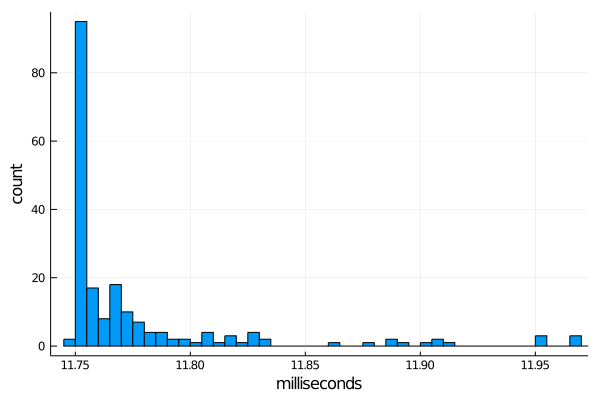

In [19]:
using Statistics # bring in statistical support for standard deviations
t = c_bench.times / 1e6 # times in milliseconds
m, σ = minimum(t), std(t)

histogram(t, bins=500,
    xlim=(m - 0.01, m + σ),
    xlabel="milliseconds", ylabel="count", label="")
# # 2. C with -ffast-math

In [20]:
# If we allow C to re-arrange the floating point operations, then it'll vectorize with SIMD (single instruction, multiple data) instructions.
const Clib_fastmath = tempname()   # make a temporary file

# The same as above but with a -ffast-math flag added
open(`gcc -fPIC -O3 -msse3 -xc -shared -ffast-math -o $(Clib_fastmath * "." * Libdl.dlext) -`, "w") do f
    print(f, C_code)
end

# define a Julia function that calls the C function:
c_sum_fastmath(X::Array{Float64}) = ccall(("c_sum", Clib_fastmath), Float64, (Csize_t, Ptr{Float64}), length(X), X)

c_sum_fastmath (generic function with 1 method)

In [21]:
c_fastmath_bench = @benchmark $c_sum_fastmath($a)

BenchmarkTools.Trial: 
  memory estimate:  0 bytes
  allocs estimate:  0
  --------------
  minimum time:     4.296 ms (0.00% GC)
  median time:      4.520 ms (0.00% GC)
  mean time:        4.898 ms (0.00% GC)
  maximum time:     7.374 ms (0.00% GC)
  --------------
  samples:          1021
  evals/sample:     1

In [22]:
d["C -ffast-math"] = minimum(c_fastmath_bench.times) / 1e6  # in milliseconds

4.295901

# 3. Python's built in `sum`

The `PyCall` package provides a Julia interface to Python:

In [23]:
# using Pkg; Pkg.add("PyCall")
using PyCall

┌ Info: Precompiling PyCall [438e738f-606a-5dbb-bf0a-cddfbfd45ab0]
└ @ Base loading.jl:1278
ERROR: LoadError: LoadError: PyCall not properly installed. Please run Pkg.build("PyCall")
Stacktrace:
 [1] error(::String) at ./error.jl:33
 [2] top-level scope at /Users/wanglong/.julia/packages/PyCall/zqDXB/src/startup.jl:44
 [3] include(::Function, ::Module, ::String) at ./Base.jl:380
 [4] include at ./Base.jl:368 [inlined]
 [5] include(::String) at /Users/wanglong/.julia/packages/PyCall/zqDXB/src/PyCall.jl:1
 [6] top-level scope at /Users/wanglong/.julia/packages/PyCall/zqDXB/src/PyCall.jl:34
 [7] include(::Function, ::Module, ::String) at ./Base.jl:380
 [8] include(::Module, ::String) at ./Base.jl:368
 [9] top-level scope at none:2
 [10] eval at ./boot.jl:331 [inlined]
 [11] eval(::Expr) at ./client.jl:467
 [12] top-level scope at ./none:3
in expression starting at /Users/wanglong/.julia/packages/PyCall/zqDXB/src/startup.jl:41
in expression starting at /Users/wanglong/.julia/packages/PyCal

LoadError: Failed to precompile PyCall [438e738f-606a-5dbb-bf0a-cddfbfd45ab0] to /Users/wanglong/.julia/compiled/v1.5/PyCall/GkzkC_03tqh.ji.

In [ ]:
# get the Python built-in "sum" function:
pysum = pybuiltin("sum")

In [ ]:
pysum(a)

In [ ]:
pysum(a) ≈ sum(a)

In [ ]:
py_list_bench = @benchmark $pysum($a)

In [ ]:
d["Python built-in"] = minimum(py_list_bench.times) / 1e6
d

# 4. Python: `numpy`

## Takes advantage of hardware "SIMD", but only works when it works.

`numpy` is an optimized C library, callable from Python.
It may be installed within Julia as follows:

In [ ]:
# using Pkg; Pkg.add("Conda")
using Conda

In [ ]:
# Conda.add("numpy")

In [ ]:
numpy_sum = pyimport("numpy")["sum"]

py_numpy_bench = @benchmark $numpy_sum($a)

In [ ]:
numpy_sum(a)

In [ ]:
numpy_sum(a) ≈ sum(a)

In [ ]:
d["Python numpy"] = minimum(py_numpy_bench.times) / 1e6
d

# 5. Python, hand-written

In [ ]:
py"""
def py_sum(A):
    s = 0.0
    for a in A:
        s += a
    return s
"""

sum_py = py"py_sum"

In [ ]:
py_hand = @benchmark $sum_py($a)

In [ ]:
sum_py(a)

In [ ]:
sum_py(a) ≈ sum(a)

In [ ]:
d["Python hand-written"] = minimum(py_hand.times) / 1e6
d

# 6. Julia (built-in)

## Written directly in Julia, not in C!

In [ ]:
@which sum(a)

In [ ]:
j_bench = @benchmark sum($a)

In [ ]:
d["Julia built-in"] = minimum(j_bench.times) / 1e6
d

# 7. Julia (hand-written)

In [ ]:
function mysum(A)
    s = 0.0 # s = zero(eltype(a))
    for a in A
        s += a
    end
    s
end

In [ ]:
j_bench_hand = @benchmark mysum($a)

In [ ]:
d["Julia hand-written"] = minimum(j_bench_hand.times) / 1e6
d

# 8. Julia (hand-written w. simd)

In [ ]:
function mysum_simd(A)
    s = 0.0 # s = zero(eltype(A))
    @simd for a in A
        s += a
    end
    s
end

In [ ]:
j_bench_hand_simd = @benchmark mysum_simd($a)

In [ ]:
mysum_simd(a)

In [ ]:
d["Julia hand-written simd"] = minimum(j_bench_hand_simd.times) / 1e6
d

# Summary

In [ ]:
for (key, value) in sort(collect(d), by=last)
    println(rpad(key, 25, "."), lpad(round(value; digits=1), 6, "."))
end